# Modelo de clasificación de sonidos con SGD (Stochastic Gradient Descent)

importación de librerías

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## previsualización de los datos

In [2]:
dataset = pd.read_csv('sonidosEtiquetados.csv')
dataset.head()

,frecuencia1,ugen1,frecuencia2,ugen2,frecuencia3,ugen3,clase
0,16838,9,7579,4,12851,0,1
1,5031,8,8673,4,11376,9,1
2,10285,2,10089,5,17702,9,0
3,1779,9,7285,8,2744,8,1
4,16730,7,4083,2,4379,11,1


Se visualiza la combinación de los datos por cada clase

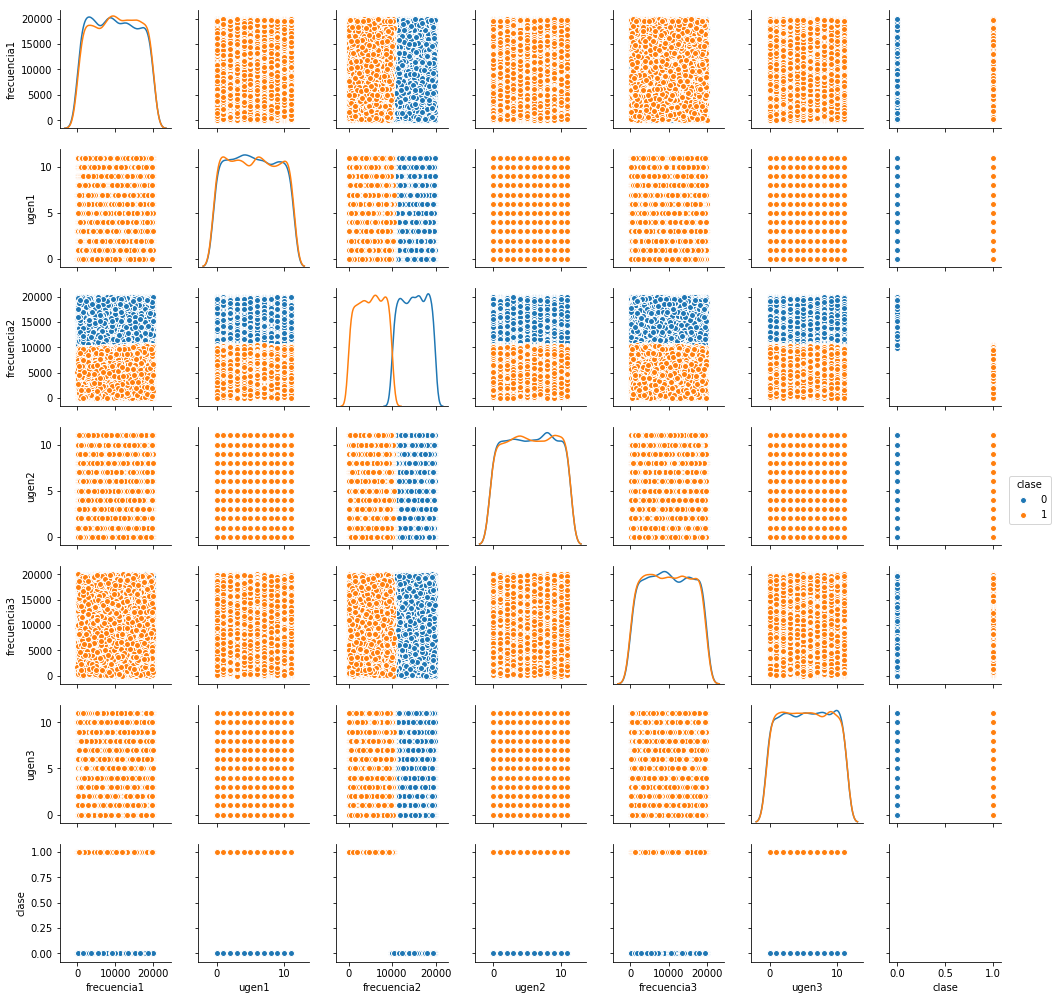

In [3]:
seaborn.pairplot(dataset, hue="clase", size=2, diag_kind="kde")
plt.show()

## Preparación de los datos de entrenamiento

Inicialmente estandarizamos la representación de la columna a predecir (clase) con la técnica “One Hot Encoding” con el fin de que tensorflow pueda hacer uso de dicha representación para realizar la predicción. A continuación se ilustra el funcionamiento de la técnica “One Hot Encoding”
![](https://cdn-images-1.medium.com/max/1400/0*T5jaa2othYfXZX9W.)

In [4]:
sonidos_lb = LabelBinarizer()
Y = sonidos_lb.fit_transform(dataset.clase.values)

Adicionalmente se normalizan los valores de las columnas predictoras con el fin de mejorar el gradiente descendiente, que posteriormente usaremos para la reducción del error de predicción. 

Para esta tarea definimos que todas las columnas (excepto la clase) son aportantes para el modelo, por lo cual determinamos que las variables predictoras serían: frecuencia1, ugen1, frecuencia2, ugen2, frecuenci3, ugen3 y nuestro objetivo será lograr predecir la “clase” del sonido (0,1).




In [6]:
FEATURES = dataset.columns[0:6]
X_data = dataset[FEATURES].as_matrix()
X_data = normalize(X_data)

Nuestro siguiente paso consiste en la partición de la data en dos, una para training o otra para test; este paso es requerido al momento de trabajar con algoritmos de machine learning y nos permite prevenir el overfitting (modelo sobre ajustado) y una mejor referencia del rendimiento de nuestra red. En nuestro caso usaremos el 30% de la información para test y el 70% para train correspondientes a 3000 y 7000 registros respectivamente. 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y, test_size=0.3, random_state=1)
X_train.shape

(7000, 6)

## Parámetros de entrenamiento

Se determinan los parámetros de entrenamiento. La tasa de aprendizaje del gradiente decendiente y la cantidad de épocasque se entrenará el modelo; también se defienen algunos parámetros que se usarán la la construcción del grafo computacional.

In [8]:
# Parameters
learning_rate = 0.01
training_epochs = 100

# Neural Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 128 # 1st layer number of neurons
n_input = X_train.shape[1] # input shape (7000, 6)
n_classes = y_train.shape[1] # classes to predict

## Grafo comutacional

Luego de tener listos nuestros datos para el entrenamiento procedemos a escribir el grafo computacional que representará nuestra red neuronal en tensorflow

In [10]:
# Inputs
X = tf.placeholder("float", shape=[None, n_input])
y = tf.placeholder("float", shape=[None, n_classes])

# Dictionary of Weights and Biases
weights = {
  'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
  'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
  'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
  'b1': tf.Variable(tf.random_normal([n_hidden_1])),
  'b2': tf.Variable(tf.random_normal([n_hidden_2])),
  'out': tf.Variable(tf.random_normal([n_classes]))
}

In [11]:
# Model Forward Propagation step
def forward_propagation(x):
    # Hidden layer1
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)

    # Output fully connected layer
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] 
    return out_layer


# Model Outputs
yhat = forward_propagation(X)
ypredict = tf.argmax(yhat, axis=1)

Como se puede observa la capa inicial (layer_1) toma como entrada el parámetro x el cual contiene un vector con nuestras variables predictoras; cada capa tiene asociada sus pesos y sus sesgos que representan las variables que se irán calibrando durante el entrenamiento. La ecuación que representa cada capa es básicamente una ecuación matricial de la forma

\begin{align}
Y = A*X + B
\end{align}


Donde A representa los pesos asociados  a la capa, X es el resultado de la capa anterior y B los sesgos asociados a la capa. 

Una vez definida nuestra función predictora “yhat” se procede a determinar la función de costo, para la cual usamos una función que provee tensorflow llamada “softmax_cross_entropy_with_logits” la cual aplica el softmax a nuestra variable yhat y luego calcula la entropía cruzada entre esto y los datos reales. 

Para reducir el costo, utilizamos el optimizador de gradiente descendiente (gradient descent optimizer) 



In [12]:
# Backward propagation
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

train_op = optimizer.minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Entrenamiento del modelo

Una vez definido todo nuestro grafo computacional se procede al entrenamiento del modelo con la ayuda de tensorflow, el cual consiste en un proceso iterativo para la calibración de los pesos y sesgos. Usamos 100 epocas para el entrenamiento, por cada época los datos pasan por todas las capas y se realiza la calibración, también se calcula la precisión de la predicción para los datos de entrenamiento y prueba, la idea es que estos valores nos sean muy diferentes con el fin de evitar un overfitting. Al final del entrenamiento tendremos los pesos y sesgos de cada capa calibrados y podremos usarlos para realizar predicciones con nuevos datos. 

In [13]:
# Initializing the variables
init = tf.global_variables_initializer()

from datetime import datetime
startTime = datetime.now()

with tf.Session() as sess:
    sess.run(init)
    
    #writer.add_graph(sess.graph)
    #EPOCHS
    for epoch in range(training_epochs):
        #Stochasting Gradient Descent
        for i in range(len(X_train)):
            summary = sess.run(train_op, feed_dict={X: X_train[i: i + 1], y: y_train[i: i + 1]})
        
        train_accuracy = np.mean(np.argmax(y_train, axis=1) == sess.run(ypredict, feed_dict={X: X_train, y: y_train}))
        test_accuracy  = np.mean(np.argmax(y_test, axis=1) == sess.run(ypredict, feed_dict={X: X_test, y: y_test}))
                
        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%" % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))
        #print("Epoch = %d, train accuracy = %.2f%%" % (epoch + 1, 100. * train_accuracy))

    sess.close()
print("Time taken:", datetime.now() - startTime)

Epoch = 1, train accuracy = 73.66%, test accuracy = 74.83%
Epoch = 2, train accuracy = 74.81%, test accuracy = 75.60%
Epoch = 3, train accuracy = 76.44%, test accuracy = 77.03%
Epoch = 4, train accuracy = 77.11%, test accuracy = 77.70%
Epoch = 5, train accuracy = 77.53%, test accuracy = 77.47%
Epoch = 6, train accuracy = 77.67%, test accuracy = 77.83%
Epoch = 7, train accuracy = 78.16%, test accuracy = 78.40%
Epoch = 8, train accuracy = 77.59%, test accuracy = 77.67%
Epoch = 9, train accuracy = 77.01%, test accuracy = 76.33%
Epoch = 10, train accuracy = 77.14%, test accuracy = 76.23%
Epoch = 11, train accuracy = 78.31%, test accuracy = 78.80%
Epoch = 12, train accuracy = 79.53%, test accuracy = 79.93%
Epoch = 13, train accuracy = 79.56%, test accuracy = 80.03%
Epoch = 14, train accuracy = 78.74%, test accuracy = 79.27%
Epoch = 15, train accuracy = 78.90%, test accuracy = 78.93%
Epoch = 16, train accuracy = 78.67%, test accuracy = 78.80%
Epoch = 17, train accuracy = 79.20%, test accurac

finalmente podremos hacer nuevas predicciones

In [26]:
#predicción
with tf.Session() as sess:
    tf.global_variables_initializer().run()    
    feed_dict = {X: [[17921,5,9524,6,6720,5]]}
    classification = sess.run(ypredict, feed_dict)
    print(classification)

[2]
